[ Check the Original webpage link !!!](https://madewithml.com/courses/foundations/data-quality/)

#Setup 
###Seeds for reproducibility

In [1]:
import numpy as np
import random


In [2]:
SEED = 1234
# Set seed for reproducibility
np.random.seed(SEED)
random.seed(SEED)


### Full dataset
We'll first train a model with the entire dataset. Later we'll remove a subset of the dataset and see the effect it has on our model.

### Load Dataset

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
from pandas.plotting import scatter_matrix


In [4]:
# Load data
url = "https://raw.githubusercontent.com/GokuMohandas/MadeWithML/main/datasets/tumors.csv"
df = pd.read_csv(url, header=0) # load
df = df.sample(frac=1).reset_index(drop=True) # shuffle
df.head()


,leukocyte_count,blood_pressure,tumor_class
0,15.335860,14.637535,benign
1,9.857535,14.518942,malignant
2,17.632579,15.869585,benign
3,18.369174,14.774547,benign
4,14.509367,15.892224,malignant


In [5]:
# Define X and y
X = df[["leukocyte_count", "blood_pressure"]].values
y = df["tumor_class"].values
print ("X: ", np.shape(X))
print ("y: ", np.shape(y))


X:  (1000, 2)
y:  (1000,)


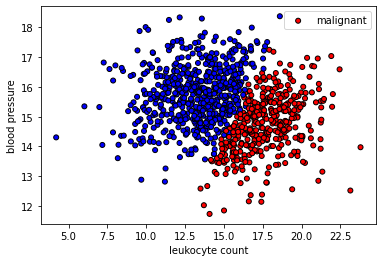

In [6]:
# Plot data
colors = {"benign": "red", "malignant": "blue"}
plt.scatter(X[:, 0], X[:, 1], c=[colors[_y] for _y in y], s=25, edgecolors="k")
plt.xlabel("leukocyte count")
plt.ylabel("blood pressure")
plt.legend(["malignant", "benign"], loc="upper right")
plt.show()


We want to choose features that have strong predictive signal for our task. If you want to improve performance, you need to continuously do feature engineering by collecting and adding new signals. So you may run into a new feature that has high correlation (orthogonal signal) with your existing features but it may still possess some unique signal to boost your predictive performance.

,leukocyte_count,blood_pressure
leukocyte_count,1.000000,-0.162875
blood_pressure,-0.162875,1.000000


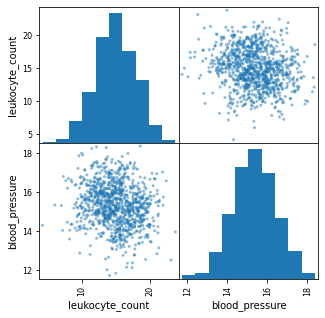

In [7]:
# Correlation matrix
scatter_matrix(df, figsize=(5, 5));
df.corr()


###Split Data

In [8]:
import collections
from sklearn.model_selection import train_test_split


In [9]:
TRAIN_SIZE = 0.70
VAL_SIZE = 0.15
TEST_SIZE = 0.15


###Stratified Train-Test Splits


Some classification problems do not have a balanced number of examples for each class label. As such, it is desirable to split the dataset into train and test sets in a way that preserves the same proportions of examples in each class as observed in the original dataset.

This is called a stratified train-test split.

We can achieve this by setting the “stratify” argument to the y component of the original dataset. This will be used by the train_test_split() function to ensure that both the train and test sets have the proportion of examples in each class that is present in the provided “y” array.

In [10]:
def train_val_test_split(X, y, train_size):
    """Split dataset into data splits."""
    X_train, X_, y_train, y_ = train_test_split(X, y, train_size=TRAIN_SIZE, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_, y_, train_size=0.5, stratify=y_)
    return X_train, X_val, X_test, y_train, y_val, y_test


In [11]:
# Create data splits
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(
    X=X, y=y, train_size=TRAIN_SIZE)
print (f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print (f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print (f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print (f"Sample point: {X_train[0]} → {y_train[0]}")


X_train: (700, 2), y_train: (700,)
X_val: (150, 2), y_val: (150,)
X_test: (150, 2), y_test: (150,)
Sample point: [14.95081332 14.86441305] → malignant


### Label encoding

In [12]:
from sklearn.preprocessing import LabelEncoder


In [13]:
# Output vectorizer
label_encoder = LabelEncoder()


In [14]:
# Fit on train data
label_encoder = label_encoder.fit(y_train)
classes = list(label_encoder.classes_)
print (f"classes: {classes}")


classes: ['benign', 'malignant']


In [15]:
# Convert labels to tokens
print (f"y_train[0]: {y_train[0]}")
y_train = label_encoder.transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)
print (f"y_train[0]: {y_train[0]}")


y_train[0]: malignant
y_train[0]: 1


In [16]:
# Class weights
counts = np.bincount(y_train)
class_weights = {i: 1.0/count for i, count in enumerate(counts)}
print (f"counts: {counts}\nweights: {class_weights}")


counts: [272 428]
weights: {0: 0.003676470588235294, 1: 0.002336448598130841}


### Standardize data


In [17]:
from sklearn.preprocessing import StandardScaler


In [18]:
# Standardize the data (mean=0, std=1) using training data
X_scaler = StandardScaler().fit(X_train)


In [19]:
# Apply scaler on training and test data (don't standardize outputs for classification)
X_train = X_scaler.transform(X_train)
X_val = X_scaler.transform(X_val)
X_test = X_scaler.transform(X_test)


In [20]:
# Check (means should be ~0 and std should be ~1)
print (f"X_test[0]: mean: {np.mean(X_test[:, 0], axis=0):.1f}, std: {np.std(X_test[:, 0], axis=0):.1f}")
print (f"X_test[1]: mean: {np.mean(X_test[:, 1], axis=0):.1f}, std: {np.std(X_test[:, 1], axis=0):.1f}")


X_test[0]: mean: -0.1, std: 1.0
X_test[1]: mean: -0.1, std: 1.0


###Model

In [21]:
import torch
from torch import nn
import torch.nn.functional as F


In [22]:
# Set seed for reproducibility
torch.manual_seed(SEED)


In [23]:
INPUT_DIM = 2 # X is 2-dimensional
HIDDEN_DIM = 100
NUM_CLASSES = 2


In [24]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x_in):
        z = F.relu(self.fc1(x_in)) # ReLU activation function added!
        z = self.fc2(z)
        return z


In [25]:
# Initialize model
model = MLP(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, num_classes=NUM_CLASSES)
print (model.named_parameters)


<bound method Module.named_parameters of MLP(
  (fc1): Linear(in_features=2, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=2, bias=True)
)>


### Training


In [26]:
from torch.optim import Adam


In [27]:
LEARNING_RATE = 1e-3
NUM_EPOCHS = 5
BATCH_SIZE = 32


In [28]:
# Define Loss
class_weights_tensor = torch.Tensor(list(class_weights.values()))
loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)


In [29]:
# Accuracy
def accuracy_fn(y_pred, y_true):
    n_correct = torch.eq(y_pred, y_true).sum().item()
    accuracy = (n_correct / len(y_pred)) * 100
    return accuracy


In [30]:
# Optimizer
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)


In [31]:
# Convert data to tensors
X_train = torch.Tensor(X_train)
y_train = torch.LongTensor(y_train)
X_val = torch.Tensor(X_val)
y_val = torch.LongTensor(y_val)
X_test = torch.Tensor(X_test)
y_test = torch.LongTensor(y_test)


In [32]:
# Training
for epoch in range(NUM_EPOCHS*10):
    # Forward pass
    y_pred = model(X_train)

    # Loss
    loss = loss_fn(y_pred, y_train)

    # Zero all gradients
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()

    if epoch%10==0:
        predictions = y_pred.max(dim=1)[1] # class
        accuracy = accuracy_fn(y_pred=predictions, y_true=y_train)
        print (f"Epoch: {epoch} | loss: {loss:.2f}, accuracy: {accuracy:.1f}")


Epoch: 0 | loss: 0.70, accuracy: 48.4
Epoch: 10 | loss: 0.54, accuracy: 92.3
Epoch: 20 | loss: 0.43, accuracy: 97.4
Epoch: 30 | loss: 0.35, accuracy: 97.4
Epoch: 40 | loss: 0.30, accuracy: 97.4


### Evaluation

In [33]:
import json
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support

In [34]:
def get_metrics(y_true, y_pred, classes):
    """Per-class performance metrics."""
    # Performance
    performance = {"overall": {}, "class": {}}

    # Overall performance
    metrics = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    performance["overall"]["precision"] = metrics[0]
    performance["overall"]["recall"] = metrics[1]
    performance["overall"]["f1"] = metrics[2]
    performance["overall"]["num_samples"] = np.float64(len(y_true))

    # Per-class performance
    metrics = precision_recall_fscore_support(y_true, y_pred, average=None)
    for i in range(len(classes)):
        performance["class"][classes[i]] = {
            "precision": metrics[0][i],
            "recall": metrics[1][i],
            "f1": metrics[2][i],
            "num_samples": np.float64(metrics[3][i]),
        }

    return performance


In [35]:
# Predictions
y_prob = F.softmax(model(X_test), dim=1)
y_pred = y_prob.max(dim=1)[1]


In [36]:
# Performance report
performance = get_metrics(y_true=y_test, y_pred=y_pred, classes=classes)
print (json.dumps(performance, indent=2))


{
  "overall": {
    "precision": 0.9666478023014525,
    "recall": 0.9666666666666667,
    "f1": 0.9666118292205249,
    "num_samples": 150.0
  },
  "class": {
    "benign": {
      "precision": 0.9649122807017544,
      "recall": 0.9482758620689655,
      "f1": 0.9565217391304347,
      "num_samples": 58.0
    },
    "malignant": {
      "precision": 0.967741935483871,
      "recall": 0.9782608695652174,
      "f1": 0.972972972972973,
      "num_samples": 92.0
    }
  }
}


### Inference
We're going to plot a point, which we know belongs to the malignant tumor class. Our well trained model here would accurately predict that it is indeed a malignant tumor!



In [37]:
def plot_multiclass_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))
    cmap = plt.cm.Spectral

    X_test = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()
    y_pred = F.softmax(model(X_test), dim=1)
    _, y_pred = y_pred.max(dim=1)
    y_pred = y_pred.reshape(xx.shape)
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())


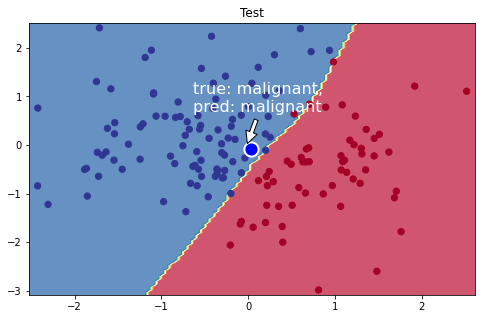

In [38]:
# Visualize the decision boundary
plt.figure(figsize=(8,5))
plt.title("Test")
plot_multiclass_decision_boundary(model=model, X=X_test, y=y_test)

# Sample point near the decision boundary
mean_leukocyte_count, mean_blood_pressure = X_scaler.transform(
    [[np.mean(df.leukocyte_count), np.mean(df.blood_pressure)]])[0]
plt.scatter(mean_leukocyte_count+0.05, mean_blood_pressure-0.05, s=200,
            c="b", edgecolor="w", linewidth=2)

# Annotate
plt.annotate("true: malignant,\npred: malignant",
             color="white",
             xy=(mean_leukocyte_count, mean_blood_pressure),
             xytext=(0.4, 0.65),
             textcoords="figure fraction",
             fontsize=16,
             arrowprops=dict(facecolor="white", shrink=0.1))
plt.show()


Great! We received great performances on both our train and test data splits. We're going to use this dataset to show the importance of data quality.

### Reduced dataset
Let's remove some training data near the decision boundary and see how robust the model is now.

### Load data


In [39]:
# Raw reduced data
url = "https://raw.githubusercontent.com/GokuMohandas/MadeWithML/main/datasets/tumors_reduced.csv"
df_reduced = pd.read_csv(url, header=0) # load
df_reduced = df_reduced.sample(frac=1).reset_index(drop=True) # shuffle
df_reduced.head()


,leukocyte_count,blood_pressure,tumor_class
0,16.795186,14.434741,benign
1,13.472969,15.250393,malignant
2,9.840450,16.434717,malignant
3,16.390730,14.419258,benign
4,13.367974,15.741790,malignant


In [40]:
# Define X and y
X = df_reduced[["leukocyte_count", "blood_pressure"]].values
y = df_reduced["tumor_class"].values
print ("X: ", np.shape(X))
print ("y: ", np.shape(y))


X:  (720, 2)
y:  (720,)


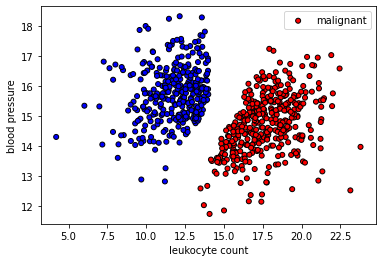

In [41]:
# Plot data
colors = {"benign": "red", "malignant": "blue"}
plt.scatter(X[:, 0], X[:, 1], c=[colors[_y] for _y in y], s=25, edgecolors="k")
plt.xlabel("leukocyte count")
plt.ylabel("blood pressure")
plt.legend(["malignant", "benign"], loc="upper right")
plt.show()


### split data

In [42]:
# Create data splits
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(
    X=X, y=y, train_size=TRAIN_SIZE)
print (f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print (f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print (f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print (f"Sample point: {X_train[0]} → {y_train[0]}")


X_train: (503, 2), y_train: (503,)
X_val: (108, 2), y_val: (108,)
X_test: (109, 2), y_test: (109,)
Sample point: [18.34509397 14.25516163] → benign


### Label encoding


In [43]:
# Encode class labels
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(y_train)
num_classes = len(label_encoder.classes_)
y_train = label_encoder.transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)


In [44]:
# Class weights
counts = np.bincount(y_train)
class_weights = {i: 1.0/count for i, count in enumerate(counts)}
print (f"counts: {counts}\nweights: {class_weights}")


counts: [272 231]
weights: {0: 0.003676470588235294, 1: 0.004329004329004329}


###Standardize data


In [45]:
# Standardize inputs using training data
X_scaler = StandardScaler().fit(X_train)
X_train = X_scaler.transform(X_train)
X_val = X_scaler.transform(X_val)
X_test = X_scaler.transform(X_test)


###Model


In [46]:
# Initialize model
model = MLP(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, num_classes=NUM_CLASSES)


###Training


In [47]:
# Define Loss
class_weights_tensor = torch.Tensor(list(class_weights.values()))
loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)


In [48]:
# Optimizer
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)


In [49]:
# Convert data to tensors
X_train = torch.Tensor(X_train)
y_train = torch.LongTensor(y_train)
X_val = torch.Tensor(X_val)
y_val = torch.LongTensor(y_val)
X_test = torch.Tensor(X_test)
y_test = torch.LongTensor(y_test)


In [50]:
# Training
for epoch in range(NUM_EPOCHS*10):
    # Forward pass
    y_pred = model(X_train)

    # Loss
    loss = loss_fn(y_pred, y_train)

    # Zero all gradients
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()

    if epoch%10==0:
        predictions = y_pred.max(dim=1)[1] # class
        accuracy = accuracy_fn(y_pred=predictions, y_true=y_train)
        print (f"Epoch: {epoch} | loss: {loss:.2f}, accuracy: {accuracy:.1f}")


Epoch: 0 | loss: 0.67, accuracy: 71.4
Epoch: 10 | loss: 0.52, accuracy: 96.8
Epoch: 20 | loss: 0.41, accuracy: 100.0
Epoch: 30 | loss: 0.33, accuracy: 100.0
Epoch: 40 | loss: 0.27, accuracy: 100.0


###Evaluation


In [51]:
# Predictions
y_prob = F.softmax(model(X_test), dim=1)
y_pred = y_prob.max(dim=1)[1]


In [52]:
# Performance report
performance = get_metrics(y_true=y_test, y_pred=y_pred, classes=classes)
print (json.dumps(performance, indent=2))


{
  "overall": {
    "precision": 1.0,
    "recall": 1.0,
    "f1": 1.0,
    "num_samples": 109.0
  },
  "class": {
    "benign": {
      "precision": 1.0,
      "recall": 1.0,
      "f1": 1.0,
      "num_samples": 59.0
    },
    "malignant": {
      "precision": 1.0,
      "recall": 1.0,
      "f1": 1.0,
      "num_samples": 50.0
    }
  }
}


###Inference
Now let's see how the same inference point from earlier performs now on the model trained on the reduced dataset.

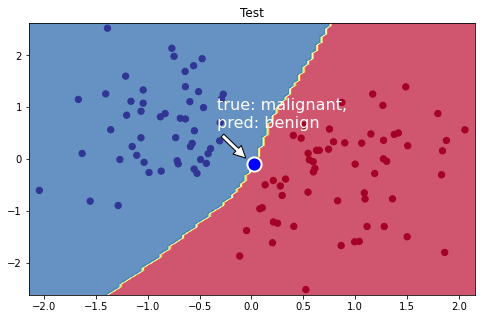

In [53]:
# Visualize the decision boundary
plt.figure(figsize=(8,5))
plt.title("Test")
plot_multiclass_decision_boundary(model=model, X=X_test, y=y_test)

# Sample point near the decision boundary (same point as before)
plt.scatter(mean_leukocyte_count+0.05, mean_blood_pressure-0.05, s=200,
            c="b", edgecolor="w", linewidth=2)

# Annotate
plt.annotate("true: malignant,\npred: benign",
             color="white",
             xy=(mean_leukocyte_count, mean_blood_pressure),
             xytext=(0.45, 0.60),
             textcoords="figure fraction",
             fontsize=16,
             arrowprops=dict(facecolor="white", shrink=0.1))
plt.show()


This is a very fragile but highly realistic scenario. Based on our reduced synthetic dataset, we have achieved a model that generalized really well on the test data. But when we ask for the prediction for the same point tested earlier (which we known is malignant), the prediction is now a benign tumor. We would have completely missed the tumor. To mitigate this, we can:

- Get more data around the space we are concerned about
- Consume predictions with caution when they are close to the decision boundary



### Takeaway
Models are not crystal balls. So it's important that before any machine learning, we really look at our data and ask ourselves if it is truly representative for the task we want to solve. The model itself may fit really well and generalize well on your data but if the data is of poor quality to begin with, the model cannot be trusted.

Once you are confident that your data is of good quality, you can finally start thinking about modeling. The type of model you choose depends on many factors, including the task, type of data, complexity required, etc.

So once you figure out what type of model your task needs, start with simple models and then slowly add complexity. You don’t want to start with neural networks right away because that may not be right model for your data and task. Striking this balance in model complexity is one of the key tasks of your data scientists. simple models → complex models

